## Chapter 6. Corner and Interest Point Detection

+ 若想試cv2.xfeatures2d.SIFT_create()請移除opencv-python後，安裝:

        pip uninstall opencv-python
        pip install opencv-contrib-python==3.4.2.17

        
OpenCV有關corner/interest point偵測的方法很多。下面網頁包含許多有用的原理說明與例子<br>
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d<br>

常用的函式
1. cornerHarris: $C=det(\Delta)-k\times trace(\Delta)^{2}$。<br>
2. preCornerDetect: $C=\sum_{\Omega}\frac{\partial^{2} I}{\partial^2 x}\sum_{\Omega}(\frac{\partial I}{\partial y})^{2}-
2\sum_{\Omega}\frac{\partial^{2} I}{\partial x\partial y}\sum_{\Omega}\frac{\partial I}{\partial x}\sum_{\Omega}\frac{\partial I}{\partial y}+\sum_{\Omega}\frac{\partial^{2} I}{\partial^2 y}\sum_{\Omega}(\frac{\partial I}{\partial x})^{2}$。<br>
3. cornerMinEigenVal: 根據 local gradient matrix 之最小 eigenvalue 做為 corner response。<br>
4. goodFeaturesToTrack: 根據 cornerHarris 或 cornerMinEigenVal 產生的 corner response 決定 Corner。<br>
5. findChessboardCorners:常用一個 Chessboard 圖樣來校正相機。尋找這些 corner 可以呼叫
findChessboardCorner。<br>
6. cornerSubPix: 呼叫 goodFeaturesToTrack 或 findChessboardCorners 找到 Corner(只能 pixel
precision)後，可以呼叫 cornerSubPix 計算更準確的位置(subpixel accuracy)。

偵測corner的步驟可以如下:
1. preCornerDetect/goodFeaturesToTrack/findChessboardCorners
2. cornerSubPix (optinal)

### 偵測 Chessboard 圖樣裡的角點

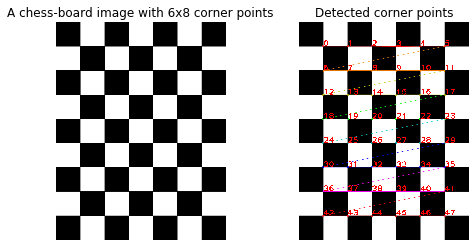

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

chessboard = cv2.imread('./test_data/chessboard.png',cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(chessboard,cmap='gray')
plt.axis('off')
plt.title('A chess-board image with 6x8 corner points')

# ˊ6x8 corners (there are 6 corner points in each row, and there are 8 such rows)
found, corners = cv2.findChessboardCorners(chessboard,(6,8)) 

if found:
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(chessboard,corners,(11,11),(-1,-1),criteria).reshape(-1,2)
    
    disp = cv2.cvtColor(chessboard,cv2.COLOR_GRAY2BGR)
    cv2.drawChessboardCorners(disp,(6,8),corners, found)
    for j in range(corners.shape[0]):
        cv2.putText(disp,str(j),(corners[j,0],corners[j,1]),cv2.FONT_HERSHEY_PLAIN,3,(0,0,255),3)
    plt.subplot(1,2,2)
    plt.imshow(disp[:,:,[2,1,0]])
    plt.axis('off')
    plt.title('Detected corner points')

plt.show()

### 使用goodFeaturesToTrack偵測角點

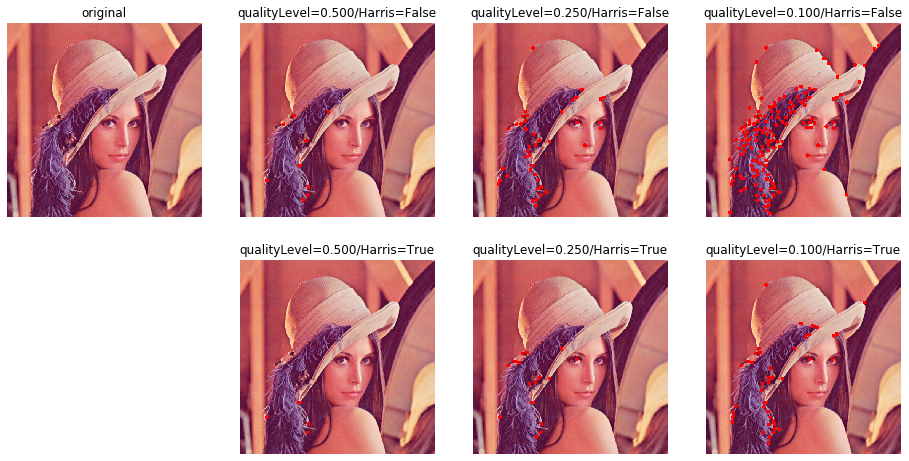

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

image = cv2.imread('./test_data/lenna.png')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(16,8))
plt.subplot(2,4,1)
plt.imshow(image[:,:,[2,1,0]])
plt.axis('off')
plt.title('original')
for uidx, useHarris in enumerate([False,True]):
    for idx, p in enumerate([0.5,0.25,0.1]):
        disp = image.copy()
        corners = cv2.goodFeaturesToTrack(gray, 1000, p, 10, useHarrisDetector=useHarris).reshape(-1,2)
        for i in range(corners.shape[0]):
            cv2.circle(disp,(corners[i,0],corners[i,1]),5,(0,0,255),-1)
        plt.subplot(2,4,idx+2+uidx*4)
        plt.imshow(disp[:,:,[2,1,0]])
        plt.title('qualityLevel={:.3f}/Harris={}'.format(p,useHarris))
        plt.axis('off')

plt.show()

### 建立特徵點對應
特徵點偵測與建立特徵點描述步驟
1. 特徵點偵測 (計算位置與scale)
2. 特徵點描述 (計算特徵)

在兩個畫面間建立特徵點對應步驟
1. 偵測畫面1裡特徵點的位置與計算其特徵
2. 偵測畫面2裡特徵點的位置與計算其特徵
3. 藉由特徵點特徵與應用Best-versus-Second Best規則來建立畫面1與畫面2特徵點對應
  * Brute-Force Matcher: cv2.BFMatcher
  * FLANN based Matcher: cv2.FlannBasedMatcher
  * cv2.flann.Index (已被移除)

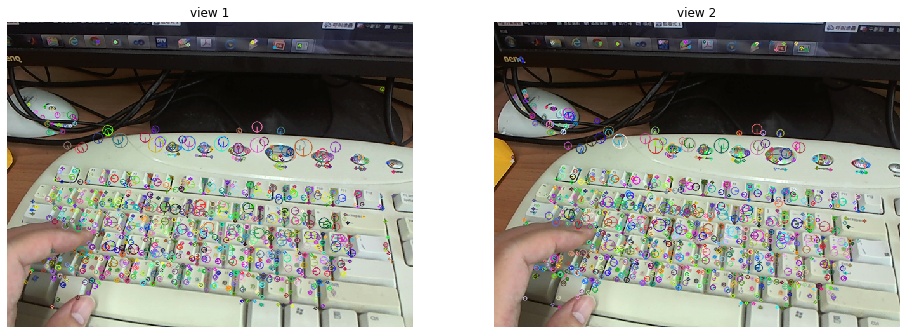

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr

%matplotlib inline

image1=cv2.imread('./test_data/scene1.png')
frame1=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)

image2=cv2.imread('./test_data/scene2.png')
frame2=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

#若想用cv2.xfeatures2d.SIFT_create()，請改變下面兩行註解
kpdetector = cv2.AKAZE_create() 
#kpdetector = cv2.xfeatures2d.SIFT_create() 

plt.figure(figsize=(16,8))

#kp1, dt1 = kpdetector.detectAndCompute(frame1,None)
kp1 = kpdetector.detect(frame1,None)
dt1 = kpdetector.compute(frame1,kp1)[1]

plt.subplot(1,2,1)
disp = cv2.drawKeypoints(image1,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(disp[:,:,[2,1,0]])
plt.axis('off')
plt.title('view 1')

#kp2, dt2 = kpdetector.detectAndCompute(frame2,None)
kp2 = kpdetector.detect(frame2,None)
dt2 = kpdetector.compute(frame2,kp2,None)[1]

plt.subplot(1,2,2)
disp = cv2.drawKeypoints(image2,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(disp[:,:,[2,1,0]])
plt.axis('off')
plt.title('view 2')
plt.show()

#### 使用Brute-Force Matcher 
當特徵點數不多時，可以使用Brute-Force Matcher比對特徵點。

# of matches:932


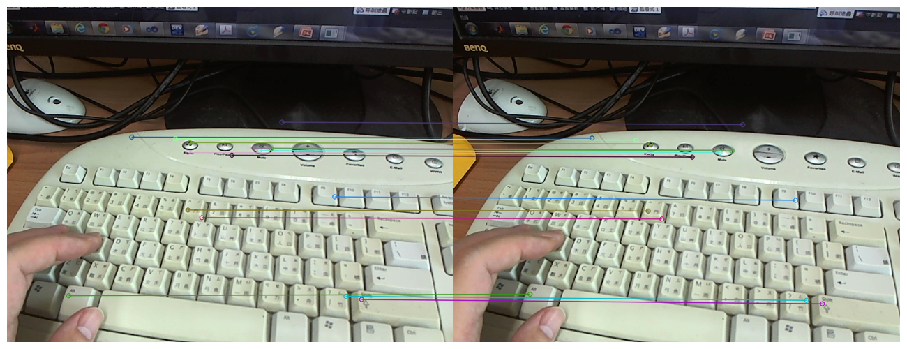

In [4]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors.
matches = bf.match(dt1,dt2)
print('# of matches:{}'.format(len(matches)))

# Sort in ascending order of distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw the best 15 matches.

disp = cv2.drawMatches(image1,kp1,image2,kp2,matches[:15], None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16,8))
plt.imshow(disp[:,:,[2,1,0]])
plt.axis('off')
plt.show()

#### 使用FLANN based Matcher
當特徵點很多時，使用cv2.FlannBasedMatcher會比較有效率。

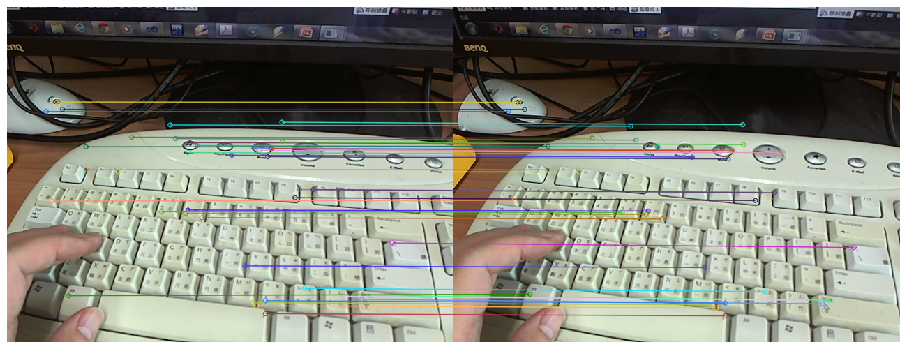

In [5]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

dt1 = dt1.astype(np.float32) #例如，AKAZE特徵為uint型態，轉成np.float32，flann才會正確執行
dt2 = dt2.astype(np.float32)

# use flann.knnMatch
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(dt1,dt2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
 
for i,(m,n) in enumerate(matches):
    if m.distance < 0.15*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchesMask = matchesMask,
                   flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

disp = cv2.drawMatchesKnn(image1,kp1,image2,kp2,matches,None,**draw_params)
plt.figure(figsize=(16,8))
plt.imshow(disp[:,:,[2,1,0]])
plt.axis('off')
plt.show()

#### 使用cv2.flann.Index (已被移除)
當training特徵點會反覆被查詢時，先將training特徵點以搜尋樹(kd-tree或k-means tree)組織起來會更有效率。(已被移除)

In [6]:
out_of_date = True
if not out_of_date:
    dt1 = dt1.astype(np.float32)
    dt2 = dt2.astype(np.float32)

    # dt1 are training points
    flann = cv2.flann.Index(dt1,dict(algorithm=FLANN_INDEX_KDTREE,
                                     distance=cv2.NORM_L2,
                                     iterations=10,
                                     branching=16,
                                     trees=50))

    # dt2 are query points
    result, dists = flann.knnSearch(dt2, knn=2) # the nearest
    print(len(dt1),len(dt2),len(result),len(dists))

    matches = []
    for query_idx, r in enumerate(dists[:,0] < 0.01*dists[:,1]):
        if r == True:
            matches.append(cv2.DMatch(query_idx,result[query_idx,0],dists[query_idx,0]))

    disp = cv2.drawMatches(image2, kp2, image1, kp1, matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(16,8))
    plt.imshow(disp[:,:,[2,1,0]])
    plt.axis('off')
    plt.show()

### Geometric Image Transformation
1. 建立特徵點對應
2. 估計幾何轉換與合成影像
  * Affine transformation
    + 估計轉換矩陣:A = cv2.getAffineTransform(src,dst) 
    
         $dst=\mathbf{A}.dot(src)$,其中 $\mathbf{A}$是一個$2\times3$矩陣。
         
    + 合成影像:warpAffine(src_img, A, dsize)
  * Homography 
    + 估計轉換矩陣:A = cv2.getPerspectiveTransform(src,dst)/cv2.findHomography(src, dst, cv2.CV_RANSAC)
    
         $[dst,1]^{T}\sim\mathbf{A}.dot([src,1]^{T})$),其中 $\mathbf{A}$是一個$3\times3$矩陣。
           
    + 合成影像:warpPerspective(src_img, A, dsize)

#### 範例: 將輸入影像以$[c_{x},c_{y}]^{T}$為中心順時針轉$\theta$後，再將中心移至$[d_{x},d_{y}]^{T}$來產生新影像。其轉換矩陣可以寫成下面樣子:
$\begin{bmatrix} x_{d}\\y_{d}\end{bmatrix}=\begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}\begin{bmatrix} x_{s}-c_{x} \\ y_{s}-c_{y} \end{bmatrix}+\begin{bmatrix} d_{x} \\ d_{y} \end{bmatrix}=\begin{bmatrix} \cos(\theta) & -\sin(\theta) & -\cos(\theta)c_{x}+\sin(\theta)c_{y} + d_{x}\\ \sin(\theta) & \cos(\theta) & -\sin(\theta)c_{x}-\cos(\theta)c_{y}+d_{y}\end{bmatrix}\begin{bmatrix} x_{s} \\ y_{s} \\ 1 \end{bmatrix}$

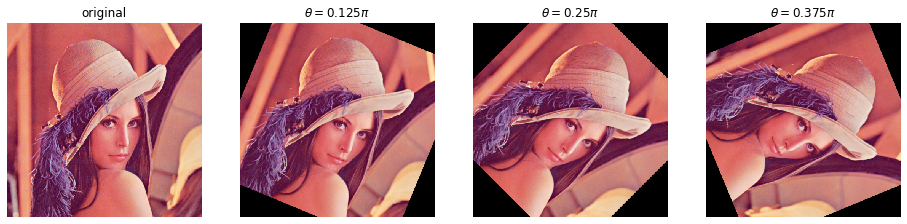

In [7]:
#
image = cv2.imread('./test_data/lenna.png')
cx = image.shape[1]/2
cy = image.shape[0]/2

dx = cx
dy = cy

plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(image[:,:,[2,1,0]])
plt.axis('off')
plt.title('original')

for idx,theta in enumerate([1/8,1/4,3/8]):
    A  = np.array([[np.cos(np.pi*theta),-np.sin(np.pi*theta),-np.cos(np.pi*theta)*cx+np.sin(np.pi*theta)*cy+dx],
                   [np.sin(np.pi*theta), np.cos(np.pi*theta),-np.sin(np.pi*theta)*cx-np.cos(np.pi*theta)*cy+dy]])

    dst_img = cv2.warpAffine(image,A,(image.shape[1],image.shape[0]))

    plt.subplot(1,4,idx+2)
    plt.imshow(dst_img[:,:,[2,1,0]])
    plt.axis('off')
    plt.title('$\\theta={}\pi$'.format(theta))
plt.show()

#### 範例: 估計Homography
這個例子示範下面處理:
1. 將輸入影像順時針轉若干角度的方式產生合成影像作為測試影像。
2. 利用特徵點的特徵描述，建立合成影像(src)與原始影像(dst)間特徵點對應關係。
3. 呼叫cv2.findHomography計算Homography $\mathbf{A}$使得$dst\sim np.dot(\mathbf{A},src)$。
4. 呼叫cv2.warpPerspective由測試影像合成原始影像。

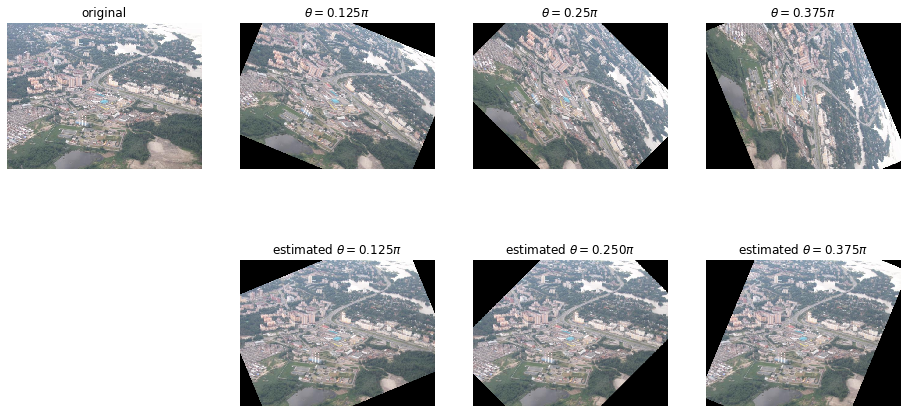

In [8]:
#若想用cv2.xfeatures2d.SIFT_create()，請改變下面兩行註解
kpdetector = cv2.AKAZE_create() 
#kpdetector = cv2.xfeatures2d.SIFT_create() 

image = cv2.imread('./test_data/aerial.jpg')
gray  = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

kp1,dp1 = kpdetector.detectAndCompute(gray,None)

cx = image.shape[1]/2
cy = image.shape[0]/2

dx = cx
dy = cy

plt.figure(figsize=(16,8))
plt.subplot(2,4,1)
plt.imshow(image[:,:,[2,1,0]])
plt.axis('off')
plt.title('original')

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
#
for idx,theta in enumerate([1/8,1/4,3/8]):
    # Step 1
    S  = np.array([[np.cos(np.pi*theta), -np.sin(np.pi*theta), -np.cos(np.pi*theta)*cx+np.sin(np.pi*theta)*cy+dx],
              [ np.sin(np.pi*theta), np.cos(np.pi*theta),  -np.sin(np.pi*theta)*cx-np.cos(np.pi*theta)*cy+dy]])

    syn_img = cv2.warpAffine(image,S,(image.shape[1],image.shape[0]))
    plt.subplot(2,4,idx+2)
    plt.imshow(syn_img[:,:,[2,1,0]])
    plt.axis('off')
    plt.title('$\\theta={}\pi$'.format(theta))
    
    target_img = cv2.cvtColor(syn_img,cv2.COLOR_BGR2GRAY)
    
    # Step 2
    kp2,dp2 = kpdetector.detectAndCompute(syn_img,None)
    
    # Match descriptors.
    matches = bf.match(dp2,dp1) # dp2 comprises query points, dp1 comprises training points
    src = []
    dst = []
    for m in matches:
        src.append(kp2[m.queryIdx].pt + (1,))
        dst.append(kp1[m.trainIdx].pt + (1,))
    src = np.array(src,dtype=np.float)
    dst = np.array(dst,dtype=np.float)
    
    # Step 3
    # find a homography to map src to dst
    A, mask = cv2.findHomography(src, dst, cv2.RANSAC) 
    
    # Step 4
    warp_img = cv2.warpPerspective(syn_img,A,(syn_img.shape[1],syn_img.shape[0]))
    
    plt.subplot(2,4,idx+6)
    plt.imshow(warp_img[:,:,[2,1,0]])
    plt.axis('off')
    v = (A[0,0]**2 + A[0,1]**2)**0.5
    plt.title('estimated $\\theta={:.3f}\pi$'.format(np.arccos(A[0,0]/v)/np.pi))
plt.show()